In [ ]:
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import more_itertools as mit
import numpy as np

from game import *
from player import Player, RandomPlayer, MaxPlayer, MinPlayer, NNPlayer, BonusCravingPlayer, MalusAdverse, GetRidOfBadCards, Robot, ParamPlayer

from analyse import read_game, plot_win_over_time

Here we will deal with high dimentional Machine State Space with standard rules:
- 5 malus cards and 10 bonus cards

Notice value function approximation may be very tricky for this problem especially because of ties: a player might be playing well (with high value cards in hands and still high bonus in the deck to be played: his expected points for the next turns is high) but it is enough to have one other player playing the same cards to lead him to lose the game.

So we will try a soft-max parametrization of the control policy to find an optimal policy given adversary players. Let's remind the expression of such model:

$$

\pi_\theta(a|s) = \frac{e^{\theta^T x(s,a)}}{\sum_c e^{\theta^T x(s,c)}}

$$

Where $\theta$ is a vector of parameter weights and $x(s,a)$ is a *vector state-action* or *score* that represents the state of the game $s$ and the choice of playing action $a$.

The question is now: *what should we include in such a vector state-action?*

First, for a given state $s$, one can play one of the remaining cards in hand $i \in \{1,2,...,15\}$, so we set the first fifteen components to $0$ except for the $i^{th}$ component which is set to $1$.
Then, we have to include interesting features that represents well the state of the game.

How many players would you like to deal with?

In [ ]:
n_cards = 2
n_game = 1
n_player = 2

100%|██████████| 10000/10000 [00:32<00:00, 312.27it/s]
Number of games: 10000
/work/StupideVautour/implementation/analyse.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["game_winner"] = df_clean["game_winner"].apply(lambda x: x[0])


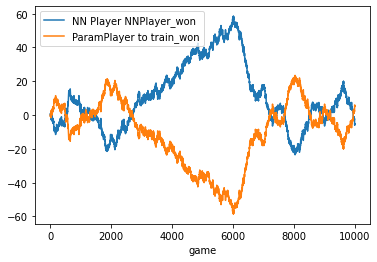

In [ ]:
n_player = 2
n_cards = 2

for _ in range(1):
    n_game = 10000
    game = Game(n_player, n_cards, n_game=n_game, random=True, verbose=False)
    game.player_list_[0] = ParamPlayer("to train", n_cards,theta_shape = n_cards*6+2**(3*n_cards)-1,alpha=2**(-12))
    game.player_list_[1] = NNPlayer(name="NNPlayer", n_cards = n_cards,learning_rate=1e-12,n_player=n_player)

    game_summary_list = []
    winner_list_list = []
    for _ in tqdm(range(n_game)):
        player_list, game_summary, winner_list = game.play()
        game_summary_list.append(game_summary)
        winner_list_list.append(list(map(str, winner_list)))
    with open(f"../data/game_summary/summary_{n_player}p_{n_game}g_{n_cards}c_example.json", "w+") as f:
        json.dump(
            {
                "player_list": list(map(str, player_list)),
                "game_summary_list": game_summary_list,
                "winner_list_list": winner_list_list,
            },
            f,
            indent=4,
        )

    player_list_nn, df_game_nn = read_game(f"../data/game_summary/summary_{n_player}p_{n_game}g_{n_cards}c_example.json", return_player=True)
    df_win = plot_win_over_time(df_game_nn, player_list=player_list_nn, window=300, display=False)
    df_reward = df_win.drop(columns=["game_winner"]).astype(int)
    df_reward = df_reward - 1/df_reward.shape[1]
    df_reward.cumsum().plot()
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3570100-157e-4a3f-b5c9-ebc0870008b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>